--2022-05-30 08:59:39--  https://i.stack.imgur.com/IAX8x.png
Resolving i.stack.imgur.com (i.stack.imgur.com)... 146.75.28.193
Connecting to i.stack.imgur.com (i.stack.imgur.com)|146.75.28.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178691 (175K) [image/png]
Saving to: ‘IAX8x.png.2’

IAX8x.png.2         100%[===================>] 174.50K  --.-KB/s    in 0.04s   

2022-05-30 08:59:39 (4.39 MB/s) - ‘IAX8x.png.2’ saved [178691/178691]



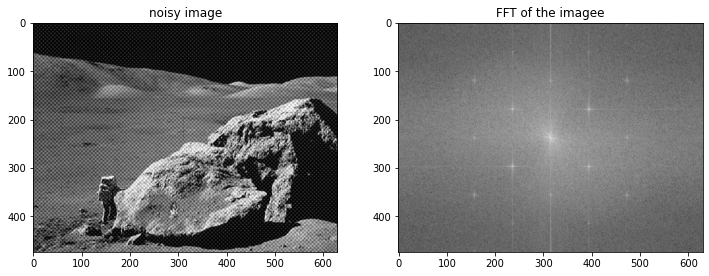

In [8]:
import cv2
from matplotlib import pyplot as plt
import numpy as np

!wget https://i.stack.imgur.com/IAX8x.png
imnois = cv2.imread('IAX8x.png', 0) # load the noisy image

imnoisfft = cv2.dft(np.float32(imnois), flags=cv2.DFT_COMPLEX_OUTPUT) #Output is a 2D complex array. 1st channel real and 2nd imaginary #For fft in opencv input image needs to be converted to float32

imnoisfftshift = np.fft.fftshift(imnoisfft) #Rearranges a Fourier transform X by shifting the zero-frequency  #component to the center of the array. #Otherwise it starts at the tope left corenr of the image (array)

magnitude_spectrumnois = 20 * np.log(cv2.magnitude(imnoisfftshift[:, :, 0], imnoisfftshift[:, :, 1])) ##Magnitude of the function is 20.log(abs(f)) #For values that are 0 we may end up with indeterminate values for log.  #So we can add 1 to the array to avoid seeing a warning. 


fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(imnois, cmap='gray')
ax1.title.set_text('noisy image')
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(magnitude_spectrumnois, cmap='gray')
ax2.title.set_text('FFT of the imagee')
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


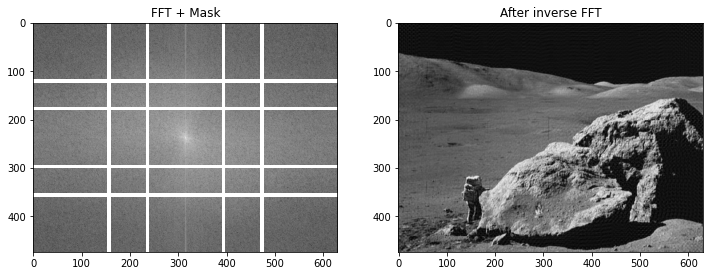

In [18]:
# making a mask to correct the repetitive noise, the mask could be designed better
rows, cols = imnois.shape
mask = np.ones((rows, cols, 2), np.uint8)
mask[176:179,:] = 0
mask[296:299,:] = 0
mask[117:122,:] = 0
mask[353:358,:] = 0
mask[:, 234:238] = 0
mask[:, 392:396] = 0
mask[:, 155:160] = 0
mask[:, 470:475] = 0

# apply mask and inverse DFT
fshift = imnoisfftshift * mask

fshift_mask_mag = 2000 * np.log(cv2.magnitude(fshift[:, :, 0], fshift[:, :, 1]))

f_ishift = np.fft.ifftshift(fshift)
img_back = cv2.idft(f_ishift)
img_back = cv2.magnitude(img_back[:, :, 0], img_back[:, :, 1])



fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(fshift_mask_mag, cmap='gray')
ax1.title.set_text('FFT + Mask')
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(img_back, cmap='gray')
ax2.title.set_text('After inverse FFT')
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log


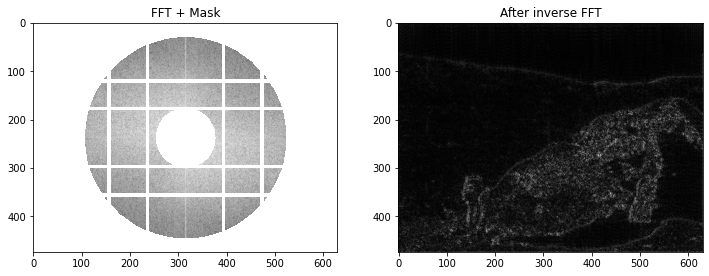

In [64]:
# Circular HPF mask, center circle is 0, remaining all ones
#Can be used for edge detection because low frequencies at center are blocked
#and only high frequencies are allowed. Edges are high frequency components.
#Amplifies noise.
# playing with r and k, the output will be different based on the frequency channel it contains
rows, cols = fshift_mask_mag.shape
crow, ccol = int(rows / 2), int(cols / 2)

mask = np.ones((rows, cols, 2), np.uint8)
r = 60
k = 150
center = [crow, ccol]
x, y = np.ogrid[:rows, :cols]
mask_area = (x - center[0]) ** 2 + (y - center[1]) ** 2 <= r*r
mask[mask_area] = 0
mask_area = (x - center[0]) ** 2 + (y - center[1]) ** 2 >= (r+k)*(r+k)

mask[mask_area] = 0
fshift_new = fshift * mask

fshift_mask_mag_new = 2000 * np.log(cv2.magnitude(fshift_new[:, :, 0], fshift_new[:, :, 1]))

##
f_ishift_new = np.fft.ifftshift(fshift_new)
img_back_new = cv2.idft(f_ishift_new)
img_back_new = cv2.magnitude(img_back_new[:, :, 0], img_back_new[:, :, 1])

fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(fshift_mask_mag_new, cmap='gray')
ax1.title.set_text('FFT + Mask')
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(img_back_new, cmap='gray')
ax2.title.set_text('After inverse FFT')
plt.show()